# 3D井字棋

## 目标和前提条件

尝试这个逻辑编程示例，学习如何解决在三维井字棋棋盘上布置X和O，以最小化完成线条或对角线数量的问题。本示例将向您展示如何使用二进制规划模型来捕获简单的逻辑约束。

这是H. Paul Williams所著《数学规划中的模型构建》第五版第272页和第327-328页的示例17。

这个建模示例属于入门级别。我们假设您对Python和Gurobi Python API有一定的了解，但您可以从示例中学习任何缺失的概念。

**下载代码库** <br /> 
您可以通过点击[这里](https://github.com/Gurobi/modeling-examples/archive/master.zip)下载包含本示例和其他示例的代码库。

---
## 问题描述

在3D井字棋棋盘上，玩家轮流放置$X$和$O$，通常当一个玩家完成一条线或对角线时游戏结束；也就是说，当他们设法在形成一条线或网格中的对角线的三个格子中放置他们的符号时。这里处理的变体是游戏继续进行直到每个格子都包含一个符号，目标是安排符号以最小化完成的线条或对角线的数量。

---
## 模型公式


### 决策变量

$\text{isX}_{ijk} \in [0,1]$: 格子$(i,j,k)$是否包含$X$（$isX=1$）或$O$（$isX=0$）？

$\text{isLine}_{l} \in [0,1]$: 线条/对角线$l$是否包含3个相同的符号？

### 目标函数

- **线条**: 最小化完成的线条或对角线的数量

\begin{equation}
\text{最小化} \quad Z = \sum_{l \in \text{Lines}}\text{isLine}_l
\end{equation}

### 约束条件

- **轮流**: 棋盘必须包含14个$X$和13个$O$（$X$先行）。

\begin{equation}
\sum_{ijk} \text{isX}_{ijk} = 14
\end{equation}

- **线条**: 对于一条未完成的线，必须有一个格子具有不同的值。简单的观察是，如果全是$X$，对应的3个二进制变量之和将为3，如果全是$O$则为0。当$isLine_l == 0$时，我们需要禁止这些结果。注意$l_0$是线$l$中的第一个格子，$l_1$是第二个，$l_2$是第三个。

\begin{equation}
\text{isLine}_l == 0 \implies isX[l_0] + isX[l_1] + isX[l_2] >= 1 \quad \forall l \in \text{Lines}
\end{equation}

\begin{equation}
\text{isLine}_l == 0 \implies isX[l_0] + isX[l_1] + isX[l_2] <= 2 \quad \forall l \in \text{Lines}
\end{equation}

---
## Python实现

我们导入Gurobi Python模块。

In [ ]:
# %pip install gurobipy

In [1]:
import gurobipy as gp
from gurobipy import GRB

# tested with Python 3.11 & Gurobi 11.0

## 模型部署

我们首先创建3D井字棋棋盘中所有可能的线条和对角线的列表。每一个都用Python元组表示，包含3个条目，每个条目给出相应格子的(i,j,k)位置。总共有49个。

In [2]:
lines = []
size = 3

for i in range(size):
    for j in range(size):
        for k in range(size):
            if i == 0:
                lines.append(((0,j,k), (1,j,k), (2,j,k)))
            if j == 0:
                lines.append(((i,0,k), (i,1,k), (i,2,k)))
            if k == 0:
                lines.append(((i,j,0), (i,j,1), (i,j,2)))
            if i == 0 and j == 0:
                lines.append(((0,0,k), (1,1,k), (2,2,k)))
            if i == 0 and j == 2:
                lines.append(((0,2,k), (1,1,k), (2,0,k)))
            if i == 0 and k == 0:
                lines.append(((0,j,0), (1,j,1), (2,j,2)))
            if i == 0 and k == 2:
                lines.append(((0,j,2), (1,j,1), (2,j,0)))
            if j == 0 and k == 0:
                lines.append(((i,0,0), (i,1,1), (i,2,2)))
            if j == 0 and k == 2:
                lines.append(((i,0,2), (i,1,1), (i,2,0)))
lines.append(((0,0,0), (1,1,1), (2,2,2)))
lines.append(((2,0,0), (1,1,1), (0,2,2)))
lines.append(((0,2,0), (1,1,1), (2,0,2)))
lines.append(((0,0,2), (1,1,1), (2,2,0)))

接下来我们创建模型和决策变量。

In [3]:
model = gp.Model('Tic_Tac_Toe')
isX = model.addVars(size, size, size, vtype=GRB.BINARY, name="isX")
isLine = model.addVars(lines, vtype=GRB.BINARY, name="isLine")

Set parameter LicenseID to value 2601452


现在我们创建约束条件。第一个约束说明棋盘将包含14个X（和13个O）：

In [4]:
x14 = model.addConstr(isX.sum() == 14)

剩余的约束建立了$isLine[]$和$isX[]$变量之间的关系。如果三个格子都包含相同的符号，则一条线是完整的。在我们的模型中，这将对应于三个相关的$isX[]$变量之和要么为3（全是$X$）要么为0（全是$O$）。就我们的目的而言，如果$isLine[] = 0$，强制要求和必须严格在这两个值之间就足够了。

In [5]:
for line in lines:
    model.addGenConstrIndicator(isLine[line], False, isX[line[0]] + isX[line[1]] + isX[line[2]] >= 1)
    model.addGenConstrIndicator(isLine[line], False, isX[line[0]] + isX[line[1]] + isX[line[2]] <= 2)

最后，我们设置优化目标，即最小化完成线条的数量。

In [6]:
model.setObjective(isLine.sum())

现在我们执行优化。

In [7]:
model.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) Ultra 5 125H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 18 logical processors, using up to 18 threads

Optimize a model with 1 rows, 76 columns and 27 nonzeros
Model fingerprint: 0x678d29e7
Model has 98 simple general constraints
  98 INDICATOR
Variable types: 0 continuous, 76 integer (76 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+01]
  GenCon rhs range [1e+00, 2e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve added 98 rows and 0 columns
Presolve time: 0.00s
Presolved: 99 rows, 76 columns, 419 nonzeros
Variable types: 0 continuous, 76 integer (76 binary)
Found heuristic solution: objective 7.0000000
Found heuristic solution: objective 6.0000000

Root relaxation: objective 0.000000e+00, 45 iterations, 0.00 seconds (0.00 work units)

  

---
## 结果

最优解只完成4条线或对角线。我们可以使用matplotlib来可视化结果（我们已经剥离了3D井字棋棋盘的第三维）。

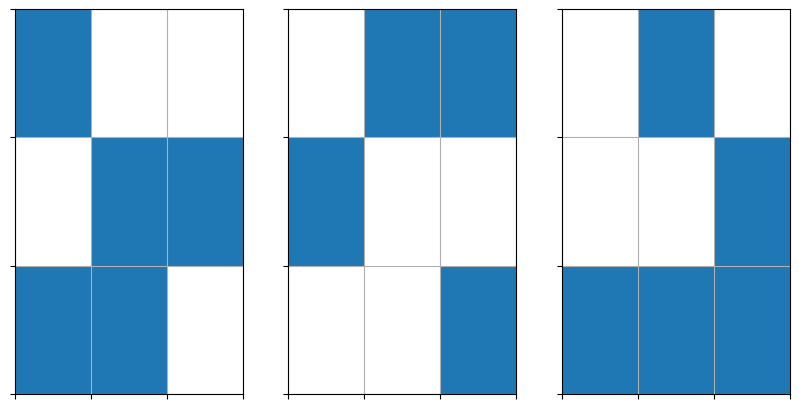

In [8]:
import matplotlib.pyplot as plt
# %matplotlib inline

fig, ax = plt.subplots(1, 3, figsize=(10,5))
for i in range(3):
    ax[i].grid()
    ax[i].set_xticks(range(4))
    ax[i].set_yticks(range(4))
    ax[i].tick_params(labelleft=False, labelbottom=False)
    
for cell in isX.keys():
    if isX[cell].x > 0.5:
        ax[cell[0]].add_patch(plt.Rectangle((cell[1],cell[2]), 1, 1))

plt.show()

---
## 参考文献

H. Paul Williams著，《数学规划中的模型构建》，第五版。

版权所有 © 2020 Gurobi Optimization, LLC